# Pairs-Trading (Beta Neutral) Strategy Analysis

The beta neutral trading strategy is a market-neutral approach designed to eliminate systematic market risk by constructing a portfolio that has a net beta of zero. This strategy aims to generate alpha (excess returns above the market) by taking both long and short positions in securities such that the overall portfolio is insulated from broad market movements.

Key Concepts:
- **Beta**: A measure of a security's volatility in relation to the overall market. A beta of 1 indicates that the security moves with the market, a beta greater than 1 indicates higher volatility than the market, and a beta less than 1 indicates lower volatility.
- **Market Neutral**: A strategy that seeks to minimize exposure to market risk, focusing on generating returns from the individual performance of securities rather than market movements.

Here's how it works:

- **Identifying a Pair / Basket of Tokens**: Identify a set of tokens with varying betas.
- **Calculating Beta**: Use historical price data to calculate the beta of each token relative to a benchmark token (e.g., BTC and ETH). This can be done using regression analysis where the token's returns are regressed against the benchmark's returns.
- **Constructing the Portfolio**: 
    - **Long Positions**: Select tokens with positive alpha (expected to outperform their beta-implied returns) and go long on these.
    - **Short Positions**: Select tokens with negative alpha (expected to underperform their beta-implied returns) and short these.
    - Ensure the weighted average beta of the long positions is equal to the weighted average beta of the short positions, resulting in a net beta of zero.
- **Position Sizing**: Calculate the dollar amount for each position to ensure that the portfolio remains beta neutral. This involves balancing the dollar value of long and short positions based on their respective betas.
- **Monitoring and Rebalancing**: Regularly monitor the portfolio to ensure it remains beta neutral. Adjust positions as necessary to maintain the desired beta neutrality, especially if there are significant changes in the market or individual tokens.

In this notebook, the pair trading negative / low correlation strategy is demonstrated using cryptocurrency price data sourced from the Binance, OKX, and Bybit APIs.

## Prepare your Environment

Ensure that the 'venv' kernel is selected for this notebook. If not, click on 'Kernel' at the top bar, select 'Change Kernel...' and select 'venv' as the kernel. For convenience, ensure that 'Always start the preferred kernel' is ticked. Click 'Select' to confirm the setting.

Install the environment's dependencies using the command below. After installation, restart the kernel to use the updated packages. To restart, click on 'Kernel' at the top bar and select 'Restart Kernel' and click on 'Restart'. Please skip this step if you have already done it.

In [2]:
pip install -r requirements.txt

     |████████████████████████████████| 1.4 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 93 kB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 142 kB 27.5 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.7 MB 14.0 MB/s eta 0:00:01
     |████████████████████████████████| 237 kB 32.8 MB/s eta 0:00:01
     |████████████████████████████████| 98 kB 20.3 MB/s eta 0:00:01
  Created wheel for ecos: filename=ecos-2.0.14-cp39-cp39-macosx_10_9_universal2.whl size=151408 sha256=68097cb7421f2beb785474010b34418e9699c16f9d331f2a872a25605dc5bdb5
  Stored in directory: /Users/gordon.oh/Library/Caches/pip/wheels/88/68/07/e0e9fb25cbb17d151b57404b1f995954acd9a6fc1e020871fd
Successfully built ecos
You should consider upgrading via the '/Users/gordon.oh/Desktop/quant_research/venv/bin/python3 -m pip install --upgrade pip' command.
Note: you 

## Import packages

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import sys
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import coint
from itertools import combinations
from statsmodels.tsa.stattools import coint
from utils import calculate_profit, plot_strategy
from data_manager import load_ts_df, process_data, sanitize_data
from typing import List
import cvxpy as cvx

## Process Price Dataframe

- Before proceeding, ensure that the price data has been downloaded using ***'data_manager.py'***.
- Enter the ***cex*** (Centralized Exchange) and ***interval*** values used for data download to load the relevant *.pkl* files and retrieve the dataframe.
- You can specify a batch of pairs to load using the ***selected_pairs*** variable. If no pairs are selected, all available pairs will be loaded by default.
- Note that some pairs might be new and may lack sufficient data within the downloaded timeframe. Such pairs will be removed based on the ***nan_remove_threshold*** setting, which defines the maximum percentage of NaN values allowed relative to the total data points. For example, with a ***nan_remove_threshold*** of 0.1, if a pair has 100 data points and 15 are NaN, the pair will be excluded.
- From the remaining pairs, you can filter the top N volume pairs using the ***top_n_volume_pairs*** parameter.
- This part of the code will also ensure that all timeseries columns have the same number of data points.
- The earliest and latest dates for all pairs will be recorded. These dates can then be used to determine the timeframe for slicing the data in the next step.

### Inputs

In [50]:
##### INPUTS #####
cex = 'binance'
interval = '4h'
nan_remove_threshold = 0.1

# Select only the pairs below to analyse. All pairs will be selected if the list is empty.
selected_pairs = []

# Select only the top N mean volume pairs from the selected pairs to analyse.
top_n_volume_pairs = 100

# Select volume filter mode. Options: ['rolling', 'mean'].
volume_filter_mode = 'rolling'
##################

In [51]:
print("\nMode: Pairs-Trading (Beta Neutral) Strategy")
print("CEX: {}".format(str(cex).capitalize()))
print("Interval: {}".format(interval))
print("NaN Remove Threshold: {}".format(nan_remove_threshold))
print("Selected pairs to analyse: {}".format(selected_pairs))
print("Top N Volume Pairs: {}".format(top_n_volume_pairs))
print("Volume Filter Mode: {}".format(str(volume_filter_mode).capitalize()))

merged_df = process_data('beta_neutral', cex, interval, nan_remove_threshold, selected_pairs,
                 top_n_volume_pairs, volume_filter_mode)

print("\n")


Mode: Pairs-Trading (Beta Neutral) Strategy
CEX: Binance
Interval: 4h
NaN Remove Threshold: 0.1
Selected pairs to analyse: []
Top N Volume Pairs: 100
Volume Filter Mode: Rolling

Columns that contains NaN values:
         Pair  NaN Count          Remark
2     ZROUSDT        538       To Remove
7   LISTAUSDT        538       To Remove
6     MEWUSDT        520       To Remove
11     ZKUSDT        519       To Remove
9      IOUSDT        484       To Remove
13  TURBOUSDT        412       To Remove
14    NOTUSDT        328       To Remove
3      BBUSDT        310       To Remove
0     REZUSDT        232       To Remove
5    OMNIUSDT        154       To Remove
8     TAOUSDT        118       To Remove
1    SAGAUSDT        105       To Remove
4    TNSRUSDT        101       To Remove
12      WUSDT         70  To Interpolate
10    ENAUSDT         64  To Interpolate

Removed 13 pairs as they contain too many NaN values.

Filtered top 100 mean volume pairs.
Successfully loaded candlestick datafr

## Sanitize the dataframe

- Slice the dataframe according to the specified ***start_date*** and ***end_date***. Choose ***start_date*** and ***end_date*** within the timeframe shown by the output of the previous cell.
- Interpolate any missing values in the dataframe.
- If the interpolation fails, just backfill with the latest valid value.
- Verify that all is as expected with an `assert` and check the shapes of 2 random pairs, which should have the same dimensions.

### Inputs

In [52]:
##### INPUTS #####
start_date = '2024-03-22'
end_date = '2024-07-22'
##################

In [53]:
print("\n")

data_sanitized, sorted_available_pairs = sanitize_data(merged_df, start_date, end_date)

if data_sanitized:
    print("-Data Check-")
    keys = list(data_sanitized.keys())
    count = 0

    for key in keys:
        print("{}'s Data Shape: {}".format(key, data_sanitized[key].shape))
        count+=1

        if count == 2:
            break
            
else:
    print("No data found.")

print("\n")



-Data Check-
BTCUSDT's Data Shape: (728, 1)
ETHUSDT's Data Shape: (728, 1)




## Compute Percentage Returns

To compute percentage returns with a time series of close data, you first need to calculate the daily returns by finding the percentage change between consecutive prices. This can be done using the formula below:
$$Percentage \space Return = \frac{Price_{t} - Price_{t-1}}{Price_{t-1}} \times 100$$
1. ${Price_{t}}$ is the calculated price on day t.
2. ${Price_{t-1}}$ is the calculated price on the previous candlestick.

In a pandas DataFrame, this can be efficiently computed using the pct_change() method on the price column. The resulting series represents the daily percentage returns, reflecting the day-to-day performance of the asset. Summarizing or compounding these daily returns over longer periods can provide insights into the overall performance of the asset over time.

In [54]:
print("\n")

returns = pd.DataFrame()

for pair, df in data_sanitized.items():
    tmp_return_df = df['Close'].pct_change().dropna().to_frame(name=pair)
    returns = pd.merge(returns, tmp_return_df, how='outer', left_index=True, right_index=True)

print("-Data Check-")
print("Percentage Returns' Data Shape (should be 1 row lesser than printed above): {}".format(returns.shape))
print("\n")




-Data Check-
Percentage Returns' Data Shape (should be 1 row lesser than printed above): (727, 100)




## Market Neutral Optimization

In order to be able to compute market neutral weights, we need the VCV matrix of the constituents and the betas to market.
Recall that portfolio beta is equal to the sum of the (weighted) beta of the constituents

In [55]:
full_covmat = returns.cov()
full_covmat.head()

,BTCUSDT,ETHUSDT,SOLUSDT,1000PEPEUSDT,XRPUSDT,WLDUSDT,WIFUSDT,1000SATSUSDT,DOGEUSDT,PEOPLEUSDT,...,YGGUSDT,HBARUSDT,SANDUSDT,MEMEUSDT,GRTUSDT,CFXUSDT,AXSUSDT,BIGTIMEUSDT,AXLUSDT,POLYXUSDT
BTCUSDT,0.000055,0.000057,0.000073,0.000109,0.000046,0.000090,0.000117,0.000101,0.000082,0.000080,...,0.000092,0.000066,0.000074,0.000088,0.000089,0.000082,0.000070,0.000090,0.000075,0.000087
ETHUSDT,0.000057,0.000084,0.000085,0.000147,0.000055,0.000113,0.000137,0.000124,0.000096,0.000105,...,0.000117,0.000082,0.000093,0.000114,0.000107,0.000110,0.000091,0.000118,0.000092,0.000099
SOLUSDT,0.000073,0.000085,0.000162,0.000193,0.000076,0.000160,0.000236,0.000178,0.000134,0.000152,...,0.000166,0.000116,0.000128,0.000154,0.000156,0.000157,0.000126,0.000164,0.000143,0.000150
1000PEPEUSDT,0.000109,0.000147,0.000193,0.000505,0.000115,0.000256,0.000391,0.000285,0.000230,0.000272,...,0.000264,0.000214,0.000201,0.000288,0.000220,0.000238,0.000193,0.000265,0.000203,0.000229
XRPUSDT,0.000046,0.000055,0.000076,0.000115,0.000094,0.000113,0.000122,0.000111,0.000089,0.000090,...,0.000115,0.000079,0.000093,0.000106,0.000098,0.000112,0.000086,0.000117,0.000091,0.000097


## Select Pairs for Detailed Analysis

- Please select any pair combination from the output below.

In [56]:
print("\nSelectable pairs:")

for pair in sorted_available_pairs:
    print("- {}".format(pair))

print("\n")


Selectable pairs:
- 1000BONKUSDT
- 1000FLOKIUSDT
- 1000LUNCUSDT
- 1000PEPEUSDT
- 1000RATSUSDT
- 1000SATSUSDT
- 1000SHIBUSDT
- AAVEUSDT
- ADAUSDT
- AEVOUSDT
- ALICEUSDT
- ALTUSDT
- APEUSDT
- APTUSDT
- ARBUSDT
- ARKMUSDT
- ARKUSDT
- ARUSDT
- ATOMUSDT
- AVAXUSDT
- AXLUSDT
- AXSUSDT
- BAKEUSDT
- BCHUSDT
- BIGTIMEUSDT
- BLURUSDT
- BNBUSDT
- BNXUSDT
- BOMEUSDT
- BONDUSDT
- BTCUSDT
- CFXUSDT
- CRVUSDT
- DARUSDT
- DOGEUSDT
- DOTUSDT
- DYDXUSDT
- DYMUSDT
- ENAUSDT
- ENSUSDT
- EOSUSDT
- ETCUSDT
- ETHFIUSDT
- ETHUSDT
- FETUSDT
- FILUSDT
- FLMUSDT
- FTMUSDT
- GALAUSDT
- GRTUSDT
- HBARUSDT
- HIGHUSDT
- ICPUSDT
- INJUSDT
- JASMYUSDT
- JTOUSDT
- JUPUSDT
- LDOUSDT
- LINKUSDT
- LOOMUSDT
- LPTUSDT
- LTCUSDT
- MANTAUSDT
- MATICUSDT
- MAVIAUSDT
- MEMEUSDT
- MKRUSDT
- MYROUSDT
- NEARUSDT
- OMUSDT
- ONDOUSDT
- OPUSDT
- ORDIUSDT
- PENDLEUSDT
- PEOPLEUSDT
- PIXELUSDT
- POLYXUSDT
- PYTHUSDT
- RUNEUSDT
- SANDUSDT
- SEIUSDT
- SOLUSDT
- STRKUSDT
- STXUSDT
- SUIUSDT
- TIAUSDT
- TONUSDT
- TRBUSDT
- TRXUSDT
- UNIUS

## Inputs

In [86]:
##### INPUTS #####
benchmark_token = 'BTCUSDT'
##################

In [87]:
betas = full_covmat[benchmark_token] / full_covmat.loc[benchmark_token, benchmark_token]
betas.drop(benchmark_token, inplace=True)
betas = betas.sort_index()
betas.head()

1000BONKUSDT     2.043690
1000FLOKIUSDT    1.909978
1000LUNCUSDT     1.288648
1000PEPEUSDT     1.974928
1000RATSUSDT     1.961269
Name: BTCUSDT, dtype: float64

## CVXPY Optimization Function

We are going to setup a minimization problem.
We want to minimize the portofolio variance like in a simple MV framework, but subject to an additional constrain:
The sum of the constituents (weighted) betas must add up to 0, in order to achieve market neutrality

In [88]:
def optimize_beta_neutral_portfolio(cov_matrix, mkt_betas, lower_bound=-1.0, upper_bound=1.0) -> pd.DataFrame:
    n = cov_matrix.shape[1]
    weights = cvx.Variable(n)
    pf_var = cvx.quad_form(weights, cov_matrix.values)
    objective = cvx.Minimize(pf_var)

    constraints = [
        weights >= lower_bound, 
        weights <= upper_bound, 
        weights.T @ mkt_betas == 0,
        cvx.sum(weights) == 1
    ]

    prob = cvx.Problem(objective, constraints)
    if not prob.is_dcp():
        raise Exception("Problem is not DCP")

    # prob.solve(solver=cvx.CLARABEL)
    prob.solve()
    if prob.status != cvx.OPTIMAL:
        raise Exception("Optimization problem is not solvable")

    weights = weights.value

    sum_weights = np.sum(np.abs(weights))
    weights = weights / sum_weights

    weights = pd.Series(weights, index=cov_matrix.columns).to_frame(name='weights')

    return weights

covmat = returns.drop(columns=[benchmark_token]).cov()  # we need to drop mkt figures from the vcv matrix
lower_bound = -1.0
upper_bound = 1.0
weights = optimize_beta_neutral_portfolio(covmat, betas, lower_bound, upper_bound)
weights

# # Mkt neutral portfolio
# covmat = returns.drop(columns=[benchmark_token]).cov()  # we need to drop mkt figures from the vcv matrix
# num_weights = covmat.shape[1]  # number of constituents
# x = cvx.Variable(num_weights)  # the variable that is allowed to change in the optimization function
# port_var = cvx.QuadForm(x, covmat)  # portfolio variance
# objective = cvx.Minimize(port_var)  # the objective function to be minimized

# # Constraints on concentration
# lower_bound = -1.0
# upper_bound = 1.0

# constraints = [x >= lower_bound,
#                x <= upper_bound,
#                sum(x) == 1,
#                x.T @ betas == 0.0]

# # solving the objective
# problem = cvx.Problem(objective, constraints)
# if not problem.is_dcp():
#     raise Exception("Problem is not DCP")
# problem.solve(solver=cvx.CLARABEL)
# if problem.status != cvx.OPTIMAL:
#     raise Exception("Optimization problem is not solvable")

# x = x.value
# x

,weights
ETHUSDT,-0.015388
SOLUSDT,-0.006787
1000PEPEUSDT,0.000948
XRPUSDT,-0.031328
WLDUSDT,-0.008980
...,...
CFXUSDT,0.001166
AXSUSDT,0.077798
BIGTIMEUSDT,-0.014641
AXLUSDT,0.005043


In [77]:
# Convert to Pandas to ease of read
w = pd.Series(weights, index=covmat.columns)
w.round(5).head()

ValueError: Data must be 1-dimensional, got ndarray of shape (99, 1) instead

## Plot Portfolio Weights

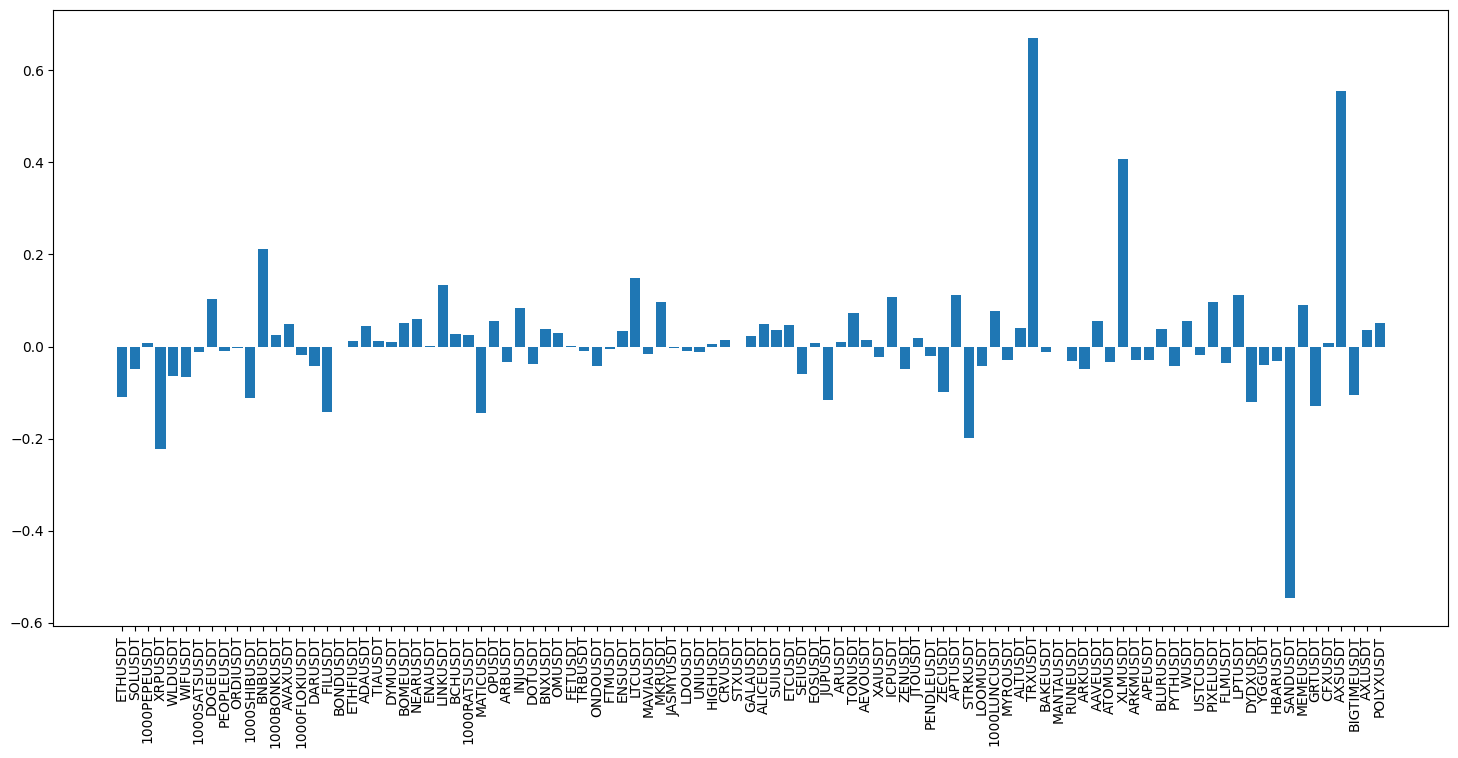

In [89]:
plt.figure(figsize=(18, 8))
plt.bar(w.index, w.values)
plt.xticks(rotation = 90);

## Rolling Portfolio Beta

In [90]:
roll_covmat = returns.rolling(window=8).cov().dropna()
roll_covmat.head()

BTCUSDT   ETHUSDT   SOLUSDT  1000PEPEUSDT  \
Open Time                                                                      
2024-03-24 04:00:00 BTCUSDT       0.000040  0.000049  0.000036      0.000071   
                    ETHUSDT       0.000049  0.000064  0.000042      0.000087   
                    SOLUSDT       0.000036  0.000042  0.000042      0.000071   
                    1000PEPEUSDT  0.000071  0.000087  0.000071      0.000149   
                    XRPUSDT       0.000044  0.000057  0.000036      0.000072   

                                   XRPUSDT   WLDUSDT   WIFUSDT  1000SATSUSDT  \
Open Time                                                                      
2024-03-24 04:00:00 BTCUSDT       0.000044  0.000134  0.000071      0.000041   
                    ETHUSDT       0.000057  0.000181  0.000098      0.000057   
                    SOLUSDT       0.000036  0.000141  0.000084      0.000034   
                    1000PEPEUSDT  0.000072  0.000268  0.000140      0.000085   
                    XRPUSDT       0.000055  0.000145  0.000069      0.000050   

                                  DOGEUSDT  PEOPLEUSDT  ...   YGGUSDT  \
Open Time                                               ...             
2024-03-24 04:00:00 BTCUSDT       0.000079    0.000060  ...  0.000123   
                    ETHUSDT       0.000088    0.000084  ...  0.000173   
                    SOLUSDT       0.000062    0.000058  ...  0.000085   
                    1000PEPEUSDT  0.000146    0.000117  ...  0.000269   
                    XRPUSDT       0.000090    0.000069  ...  0.000116   

                                  HBARUSDT  SANDUSDT  MEMEUSDT   GRTUSDT  \
Open Time                                                                  
2024-03-24 04:00:00 BTCUSDT       0.000046  0.000066  0.000091  0.000054   
                    ETHUSDT       0.000058  0.000081  0.000115  0.000068   
                    SOLUSDT       0.000041  0.000056  0.000089  0.000052   
                    1000PEPEUSDT  0.000086  0.000139  0.000184  0.000093   
                    XRPUSDT       0.000051  0.000059  0.000097  0.000062   

                                   CFXUSDT   AXSUSDT  BIGTIMEUSDT   AXLUSDT  \
Open Time                                                                     
2024-03-24 04:00:00 BTCUSDT       0.000007  0.000065     0.000072  0.000072   
                    ETHUSDT      -0.000021  0.000090     0.000088  0.000097   
                    SOLUSDT       0.000019  0.000054     0.000071  0.000065   
                    1000PEPEUSDT -0.000019  0.000129     0.000141  0.000153   
                    XRPUSDT       0.000022  0.000071     0.000070  0.000070   

                                  POLYXUSDT  
Open Time                                    
2024-03-24 04:00:00 BTCUSDT        0.000012  
                    ETHUSDT       -0.000011  
                    SOLUSDT        0.000010  
                    1000PEPEUSDT   0.000093  
                    XRPUSDT       -0.000014  

[5 rows x 100 columns]

In [91]:
# # Rolling optimization
# dates = set(roll_covmat.index.get_level_values(0))
# weights = pd.DataFrame(index=pd.Index(dates).sort_values(), columns = returns.columns)
# betas = pd.DataFrame(index=pd.Index(dates).sort_values(), columns = returns.columns)

# for dt in dates:
#     full_cov = roll_covmat.loc[dt]
#     final_cov = full_cov.drop(benchmark_token).drop(benchmark_token, axis=1)
#     final_beta = full_cov[benchmark_token].drop(benchmark_token) / full_cov.loc[benchmark_token, benchmark_token]
    
#     weight_result = optimize_beta_neutral_portfolio(final_cov, final_beta, -1, 1)
#     weights.loc[dt, :] = weight_result['weights']
#     betas.loc[dt, :] = final_beta

# Rolling optimization
date_list = set(roll_covmat.index.get_level_values(0))
weights = pd.DataFrame(index=pd.Index(date_list).sort_values(), columns = returns.columns)
betas = pd.DataFrame(index=pd.Index(date_list).sort_values(), columns = returns.columns)

for date in date_list:
    # print("Optimizing weights at time ", date)
    tmp_full_cov = roll_covmat.loc[date]
    tmp_cov = tmp_full_cov.drop(benchmark_token).drop(columns=[benchmark_token])
    tmp_betas = tmp_full_cov[benchmark_token].drop(benchmark_token) / tmp_full_cov.loc[benchmark_token, benchmark_token]
    
    weight_result = optimize_beta_neutral_portfolio(tmp_cov, tmp_betas)
    weights.loc[dt, :] = weight_result['weights']
    betas.loc[date, :] = tmp_betas

In [92]:
weights.drop(benchmark_token, axis=1, inplace=True)
betas.drop(benchmark_token, axis=1, inplace=True)

In [84]:
portfolio_beta = (weights.shift(1) * betas).dropna().sum(axis=1)
portfolio_beta.head()

2024-07-05    1.057316
dtype: object

Text(0.5, 1.0, 'Mkt Neutral Portfolio Rolling Beta to Market')

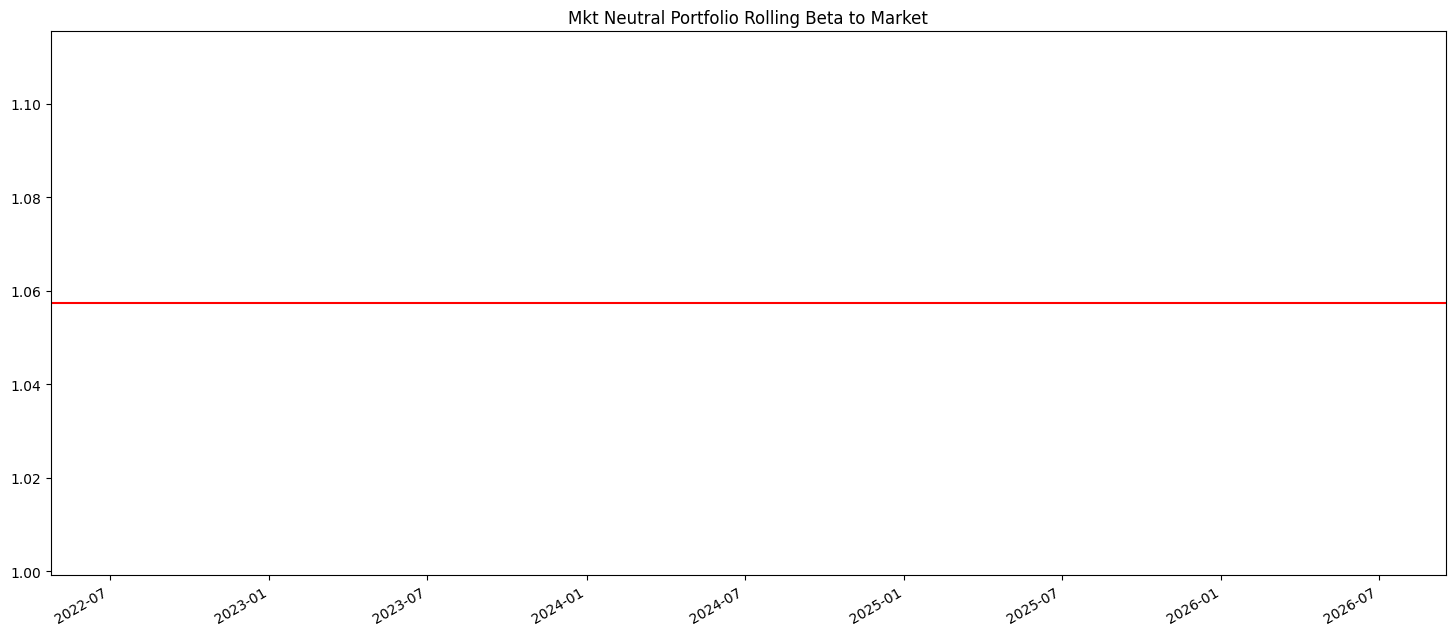

In [93]:
portfolio_beta.plot(figsize=(18, 8))
plt.axhline(portfolio_beta.mean(), color="red")
plt.title("Mkt Neutral Portfolio Rolling Beta to Market")